In [1]:
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'couplingSettings.set'
argv2 = r'modelPaths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF2DFM/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

In [5]:
PCR_config_fn = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')
print(PCR_in_dir)
print(PCR_config_fn)
print(PCR_out_dir)

PCR_bmi = PCR_model(PCR_config_fn, PCR_in_dir, PCR_out_dir,
                            start_date, end_date,)

/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/setup_PCR_30min_Elbe.ini
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR


## create CMF model BMI object

In [6]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
print(CMF_engine)
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date, dt=86400)


/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/cama-flood_bmi/src/libcama.so


## create DFM model BMI object

In [7]:
DFM_engine = os.path.join(cwd, options['DFM_engine']['DFM_path'])
DFM_model_dir = os.path.join(cwd, options['hydrodynamic_model']['model_dir'])
DFM_config_fn = os.path.join(DFM_model_dir, options['hydrodynamic_model']['model_file'])
DFM_out_dir = os.path.join(out_dir, 'DFM')
print(DFM_engine)
print(DFM_model_dir)
print(DFM_config_fn)
print(DFM_out_dir)


DFM_bmi = DFM_model(DFM_engine, DFM_config_fn, DFM_model_dir, DFM_out_dir,
                              start_date, end_date, dt=86400.)

/home/jannis/Programmes/DFLOWFM/lib/libdflowfm.so
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/DFM_Elbe/delta/DFM_Elbe_VU.mdu
/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/DFM


## intitialize DFM model

In [8]:
# initialize DFM first to expose model coordinates via BMI
DFM_bmi.initialize()

## couple grids based on CMF inpmat file

In [9]:
# couple grids
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## couple CMF to DFM based on 1d DFM indices

Couple external 1d coordinates to internal model 2d grid. 

From the green cells with value 1 (green) runoff is couled for the cells with value 2 (yellow) discharge is coupled

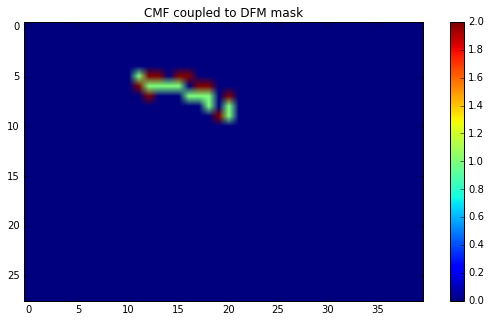

In [10]:
# get coupled dictionaries
CMF_bmi.couple_grid_to_1d(DFM_bmi)

fig = plt.figure(figsize=(10, 5))
b=fig.add_subplot(1,1,1)
plt.imshow(CMF_bmi.coupled_mask, vmin=0, vmax=2)
plt.colorbar()
b.set_title('CMF coupled to DFM mask')

note there is a difference in DFM nodes and DFM coupled nodes as some are in unit catchments that are ignored by CMF. The runoff from PCR is however mass-conservative in the CMF runoff input.

In [11]:
len(DFM_bmi.model_1d_coords), len(DFM_bmi.coupled_idx)

(1428, 1425)

## initialize CMF and PCR models

In [12]:
# initialize CMF model after nextxy had been adapted
CMF_bmi.initialize()
# initialize model after ldd has been modified
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-22 18:48:51.022713
2018-03-22 18:48:51,029 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-22 18:48:51.022713
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T18:48:51.022713.log
2018-03-22 18:48:51,031 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-22T18:48:51.022713.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-22 18:48:51,032 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this

## define exchange of values in update states function

In [13]:
def get_CMF_delta_vol():
    # coupled 2d mask
    mask = (CMF_bmi.coupled_mask > 0).astype(float)
    # total Q inflow 2D for coupled cells
    rivinf = np.copy(CMF_bmi.get_var('rivinf'))
    rivinf = np.where(np.isnan(rivinf), 0, rivinf)
    fldinf = np.copy(CMF_bmi.get_var('fldinf'))
    fldinf = np.where(np.isnan(fldinf), 0, fldinf)
    q_in = (rivinf + fldinf) * mask # [m3/s]
    # total CMF converted runoff inflow 2D for coupled cells
    runoff = np.copy(CMF_bmi.get_var('runoff')) 
    runoff = np.where(np.isnan(runoff), 0, runoff)
    runoff = runoff * mask # [m3/s]
    # take Qin + runoff in most upstream coupled cells, only runoff for other cells
    tot_flux = np.where(CMF_bmi.coupled_mask == 2, q_in + runoff, runoff)
    # convert flux to volume per day
    delta_vol = tot_flux * CMF_bmi.options['dt'] # [m3/day]
    return delta_vol 

def set_CMF_forcing():
    "coupling runoff between CMFan PCR model"
    runoff = np.copy(PCR_bmi.get_var('runoff')) # [m/day]
    runoff = np.where(np.isnan(runoff), 0, runoff)
    # note that runoff in (roffin) should be used to set PCR runoff. 
    CMF_bmi.set_var("roffin", runoff) # [m/dtin] = [m/d]

DFMidx = DFM_bmi.coupled_idx
DFM_area_1d = DFM_bmi.get_var('ba')[DFMidx]
CMFidx = CMF_bmi.coupled_idx
CMFfrac = CMF_bmi.coupled_area_frac

def set_DFM_forcing():
    CMF_delta_vol = get_CMF_delta_vol() # 2d array [m3/day]
    DFM_depth_conservative = CMF_delta_vol[CMFidx] * CMFfrac / DFM_area_1d # 1d array for coupld DFM cells [m/day]
    zerorain = np.zeros_like(np.copy(DFM_bmi.get_var('rain')))
    DFM_bmi.set_var('rain', zerorain)
    DFM_bmi.set_var_index('rain', DFMidx, DFM_depth_conservative)
    return CMF_delta_vol
        

## find location to record qsim from CMF on the fly

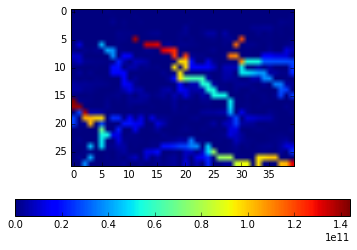

In [14]:
#- get upsteram area at comparison point in CMF
from os.path import join
upArea = np.fromfile(join(cwd, r'test_Elbe/CMF_Elbe/uparea.bin'), 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [15]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


## run coupled CMF - DFM model

In [16]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF2DFM/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f86f540bf60>


In [17]:
# run for numer of timesteps specified in set-file
tStart = datetime.now()
CMF_delta_vol_temp = 0.0
DFM_Vstart = np.sum(np.copy(DFM_bmi.get_var('vol1')))
for i in range(timeSteps):
# for i in range(365):
    PCR_bmi.update()
    set_CMF_forcing()
    CMF_bmi.update()
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
    CMF_delta_vol = set_DFM_forcing()
    CMF_delta_vol_temp += np.sum(CMF_delta_vol)
    DFM_bmi.update()
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-22 18:49:06,298 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-22 18:49:06,604 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-22 18:49:08,941 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-22 18:49:08,947 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 86400.0, timestep 86400.0
2018-03-22 18:49:09,560 coupling_PCR_FM.model_functions_v2 INFO DFM -> 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
2018-03-22 18:49:31,861 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 691200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-09
2018-03-22 18:49:31,865 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-09
INFO: pcrglobwb.update(): updating model to time 2000-01-09
2018-03-22 18:49:32,334 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
2018-03-22 18:49:33,525 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-09, timestep 9
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-10 00:00:00, timestep 86400.0
2018-03-22 18:49:33,568 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
2018-03-22 18:49:56,575 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
2018-03-22 18:49:58,683 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 1382400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-17
2018-03-22 18:49:58,690 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-17
INFO: pcrglobwb.update(): updating model to time 2000-01-17
2018-03-22 18:49:59,099 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-17, timestep 17
2018-03-22 18:50:00,302 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
2018-03-22 18:50:23,924 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-24, timestep 24
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
2018-03-22 18:50:24,035 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
2018-03-22 18:50:26,565 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2073600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-25
2018-03-22 18:50:26,572 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-25
INFO: pcrglobwb.update(): updating model to time 2000-01-25
2018-03-22 18:50:26,952 pcrglo

2018-03-22 18:50:48,798 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
INFO: pcrglobwb.update(): updating model to time 2000-02-01
2018-03-22 18:50:49,200 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
2018-03-22 18:50:50,733 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-01, timestep 32
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
2018-03-22 18:50:50,800 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
2018-03-22 18:50:52,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 2764800.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
2018-03-22 18:51:13,127 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 3369600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-09
2018-03-22 18:51:13,130 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-09
INFO: pcrglobwb.update(): updating model to time 2000-02-09
2018-03-22 18:51:13,635 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
2018-03-22 18:51:14,843 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-09, timestep 40
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-10 00:00:00, timestep 86400.0
2018-03-22 18:51:14,934 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
2018-03-22 18:51:35,932 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-17 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
2018-03-22 18:51:36,683 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4060800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-17
2018-03-22 18:51:36,687 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-17
INFO: pcrglobwb.update(): updating model to time 2000-02-17
2018-03-22 18:51:37,091 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-17, timestep 48
2018-03-22 18:51:38,311 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
2018-03-22 18:51:58,715 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-24, timestep 55
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
2018-03-22 18:51:58,802 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-25 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
2018-03-22 18:52:00,595 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 4752000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-25
2018-03-22 18:52:00,600 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-25
INFO: pcrglobwb.update(): updating model to time 2000-02-25
2018-03-22 18:52:01,083 pcrglo

2018-03-22 18:52:21,333 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-03
INFO: pcrglobwb.update(): updating model to time 2000-03-03
2018-03-22 18:52:21,735 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
2018-03-22 18:52:22,977 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-03, timestep 63
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
2018-03-22 18:52:23,035 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
2018-03-22 18:52:24,100 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 5443200.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
2018-03-22 18:52:45,306 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6048000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-22 18:52:45,309 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-22 18:52:45,739 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-22 18:52:46,954 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-22 18:52:47,012 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
2018-03-22 18:53:09,372 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
2018-03-22 18:53:10,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 6739200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-19
2018-03-22 18:53:10,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-19
INFO: pcrglobwb.update(): updating model to time 2000-03-19
2018-03-22 18:53:11,338 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-19, timestep 79
2018-03-22 18:53:12,581 coupling_PCR_FM.model_functions_v2 INFO PCR ->

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
2018-03-22 18:53:34,675 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-26, timestep 86
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
2018-03-22 18:53:34,736 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
2018-03-22 18:53:36,863 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 7430400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-27
2018-03-22 18:53:36,867 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-27
INFO: pcrglobwb.update(): updating model to time 2000-03-27
2018-03-22 18:53:37,314 pcrglo

2018-03-22 18:54:04,698 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-03
INFO: pcrglobwb.update(): updating model to time 2000-04-03
2018-03-22 18:54:05,094 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
2018-03-22 18:54:06,304 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-03, timestep 94
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
2018-03-22 18:54:06,392 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
2018-03-22 18:54:08,811 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8121600.0, timestep 86400.0
INFO: pc

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
2018-03-22 18:54:36,181 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 8726400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-22 18:54:36,184 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11
INFO: pcrglobwb.update(): updating model to time 2000-04-11
2018-03-22 18:54:36,701 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
2018-03-22 18:54:37,947 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-11, timestep 102
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-12 00:00:00, timestep 86400.0
2018-03-22 18:54:38,018 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
2018-03-22 18:55:02,982 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
2018-03-22 18:55:05,007 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 9417600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-19
2018-03-22 18:55:05,012 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-19
INFO: pcrglobwb.update(): updating model to time 2000-04-19
2018-03-22 18:55:05,502 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-19, timestep 110
2018-03-22 18:55:06,739 coupling_PCR_FM.model_functions_v2 INFO PCR -

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
2018-03-22 18:55:35,437 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-26, timestep 117
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
2018-03-22 18:55:35,722 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
2018-03-22 18:55:37,418 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 10108800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-27
2018-03-22 18:55:37,423 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-27
INFO: pcrglobwb.update(): updating model to time 2000-04-27
2018-03-22 18:55:37,831 pc

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-04
2018-03-22 18:55:58,954 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-04
INFO: pcrglobwb.update(): updating model to time 2000-05-04
2018-03-22 18:55:59,412 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
2018-03-22 18:56:00,641 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-04, timestep 125
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
2018-03-22 18:56:00,686 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 10800000.0, timestep 86400.0
2018-03-22 18:56:01,327 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
2018-03-22 18:56:20,574 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 11404800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-12
2018-03-22 18:56:20,579 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-12
INFO: pcrglobwb.update(): updating model to time 2000-05-12
2018-03-22 18:56:21,007 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
2018-03-22 18:56:22,298 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-12, timestep 133
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-13 00:00:00, timestep 86400.0
2018-03-22 18:56:22,338 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-22 18:56:44,475 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
2018-03-22 18:56:45,530 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12096000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-22 18:56:45,532 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-22 18:56:45,898 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-22 18:56:47,096 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 18:57:08,091 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
2018-03-22 18:57:09,321 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-27, timestep 148
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
2018-03-22 18:57:09,349 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
2018-03-22 18:57:10,516 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 12787200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-28
2018-03-22 18:57:10,521 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-04
2018-03-22 18:57:31,907 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-04
INFO: pcrglobwb.update(): updating model to time 2000-06-04
2018-03-22 18:57:32,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
2018-03-22 18:57:33,622 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-04, timestep 156
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
2018-03-22 18:57:33,686 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 13478400.0, timestep 86400.0
2018-03-22 18:57:35,092 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
2018-03-22 18:57:56,184 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14083200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-12
2018-03-22 18:57:56,189 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-12
INFO: pcrglobwb.update(): updating model to time 2000-06-12
2018-03-22 18:57:56,620 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
2018-03-22 18:57:57,894 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-12, timestep 164
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-13 00:00:00, timestep 86400.0
2018-03-22 18:57:57,938 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
2018-03-22 18:58:18,997 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
2018-03-22 18:58:20,031 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 14774400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-20
2018-03-22 18:58:20,033 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-20
INFO: pcrglobwb.update(): updating model to time 2000-06-20
2018-03-22 18:58:20,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-20, timestep 172
2018-03-22 18:58:21,789 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 18:58:40,439 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
2018-03-22 18:58:41,743 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-27, timestep 179
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
2018-03-22 18:58:41,826 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
2018-03-22 18:58:43,358 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 15465600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-22 18:58:43,362 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-05
2018-03-22 18:59:05,452 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-05
INFO: pcrglobwb.update(): updating model to time 2000-07-05
2018-03-22 18:59:05,891 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
2018-03-22 18:59:07,152 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-05, timestep 187
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
2018-03-22 18:59:07,186 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16156800.0, timestep 86400.0
2018-03-22 18:59:08,390 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
2018-03-22 18:59:30,541 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 16761600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-13
2018-03-22 18:59:30,545 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-13
INFO: pcrglobwb.update(): updating model to time 2000-07-13
2018-03-22 18:59:30,948 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
2018-03-22 18:59:32,203 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-13, timestep 195
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-14 00:00:00, timestep 86400.0
2018-03-22 18:59:32,299 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
2018-03-22 18:59:55,670 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
2018-03-22 18:59:57,123 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 17452800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-21
2018-03-22 18:59:57,129 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-21
INFO: pcrglobwb.update(): updating model to time 2000-07-21
2018-03-22 18:59:57,602 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-21, timestep 203
2018-03-22 18:59:58,882 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:00:17,449 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-22 19:00:18,703 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
2018-03-22 19:00:18,733 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
2018-03-22 19:00:20,047 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 18144000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-29
2018-03-22 19:00:20,054 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-05
2018-03-22 19:00:41,533 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-05
INFO: pcrglobwb.update(): updating model to time 2000-08-05
2018-03-22 19:00:42,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
2018-03-22 19:00:43,366 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-05, timestep 218
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
2018-03-22 19:00:43,402 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 18835200.0, timestep 86400.0
2018-03-22 19:00:44,801 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
2018-03-22 19:01:05,796 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 19440000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-13
2018-03-22 19:01:05,801 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-13
INFO: pcrglobwb.update(): updating model to time 2000-08-13
2018-03-22 19:01:06,265 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
2018-03-22 19:01:07,511 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-13, timestep 226
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-14 00:00:00, timestep 86400.0
2018-03-22 19:01:07,563 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
2018-03-22 19:01:29,800 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
2018-03-22 19:01:30,711 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20131200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-21
2018-03-22 19:01:30,718 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-21
INFO: pcrglobwb.update(): updating model to time 2000-08-21
2018-03-22 19:01:31,214 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-21, timestep 234
2018-03-22 19:01:32,460 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:01:55,930 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
2018-03-22 19:01:57,207 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-28, timestep 241
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
2018-03-22 19:01:57,334 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
2018-03-22 19:01:58,350 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 20822400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-29
2018-03-22 19:01:58,353 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-22 19:02:21,249 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-22 19:02:21,742 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-22 19:02:23,069 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-22 19:02:23,390 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 21513600.0, timestep 86400.0
2018-03-22 19:02:24,640 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
2018-03-22 19:02:47,147 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22118400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-13
2018-03-22 19:02:47,150 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-13
INFO: pcrglobwb.update(): updating model to time 2000-09-13
2018-03-22 19:02:47,589 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
2018-03-22 19:02:48,875 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-13, timestep 257
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-14 00:00:00, timestep 86400.0
2018-03-22 19:02:48,946 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
2018-03-22 19:03:10,129 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
2018-03-22 19:03:11,261 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 22809600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-21
2018-03-22 19:03:11,264 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-21
INFO: pcrglobwb.update(): updating model to time 2000-09-21
2018-03-22 19:03:11,776 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-21, timestep 265
2018-03-22 19:03:13,061 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:03:32,913 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
2018-03-22 19:03:34,254 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-28, timestep 272
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
2018-03-22 19:03:34,290 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
2018-03-22 19:03:36,057 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 23500800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-29
2018-03-22 19:03:36,063 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-06
2018-03-22 19:03:57,698 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-06
INFO: pcrglobwb.update(): updating model to time 2000-10-06
2018-03-22 19:03:58,223 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
2018-03-22 19:03:59,530 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-06, timestep 280
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
2018-03-22 19:03:59,604 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24192000.0, timestep 86400.0
2018-03-22 19:04:01,051 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
2018-03-22 19:04:23,338 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 24796800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-14
2018-03-22 19:04:23,345 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-14
INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-22 19:04:23,885 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-22 19:04:25,206 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-22 19:04:25,395 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
2018-03-22 19:04:47,300 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
2018-03-22 19:04:48,100 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 25488000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-22
2018-03-22 19:04:48,103 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-22
INFO: pcrglobwb.update(): updating model to time 2000-10-22
2018-03-22 19:04:48,554 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-22, timestep 296
2018-03-22 19:04:49,824 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:05:08,516 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
2018-03-22 19:05:09,776 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-29, timestep 303
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
2018-03-22 19:05:09,824 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
2018-03-22 19:05:10,560 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 26179200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-30
2018-03-22 19:05:10,565 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-06
2018-03-22 19:05:33,251 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-06
INFO: pcrglobwb.update(): updating model to time 2000-11-06
2018-03-22 19:05:33,791 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
2018-03-22 19:05:35,135 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-06, timestep 311
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
2018-03-22 19:05:35,185 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 26870400.0, timestep 86400.0
2018-03-22 19:05:36,248 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
2018-03-22 19:05:57,379 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 27475200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-14
2018-03-22 19:05:57,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-14
INFO: pcrglobwb.update(): updating model to time 2000-11-14
2018-03-22 19:05:57,862 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
2018-03-22 19:05:59,194 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-14, timestep 319
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-15 00:00:00, timestep 86400.0
2018-03-22 19:05:59,320 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
2018-03-22 19:06:22,087 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
2018-03-22 19:06:22,888 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28166400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-22
2018-03-22 19:06:22,890 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-22
INFO: pcrglobwb.update(): updating model to time 2000-11-22
2018-03-22 19:06:23,316 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-22, timestep 327
2018-03-22 19:06:24,642 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:06:43,500 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
2018-03-22 19:06:44,823 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-29, timestep 334
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
2018-03-22 19:06:44,857 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
2018-03-22 19:06:45,957 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 28857600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-30
2018-03-22 19:06:45,963 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-07
2018-03-22 19:07:06,732 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-07
INFO: pcrglobwb.update(): updating model to time 2000-12-07
2018-03-22 19:07:07,167 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
2018-03-22 19:07:08,472 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-07, timestep 342
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
2018-03-22 19:07:08,527 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-08 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 29548800.0, timestep 86400.0
2018-03-22 19:07:09,191 coupling_PCR_FM.model_functions_v2 INFO 

INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
2018-03-22 19:07:30,192 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30153600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-15
2018-03-22 19:07:30,195 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-15
INFO: pcrglobwb.update(): updating model to time 2000-12-15
2018-03-22 19:07:30,685 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
2018-03-22 19:07:32,033 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-15, timestep 350
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-16 00:00:00, timestep 86400.0
2018-03-22 19:07:32,101 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-0

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-22 19:07:53,591 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
2018-03-22 19:07:54,286 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 30844800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-22 19:07:54,288 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-22 19:07:54,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-23, timestep 358
2018-03-22 19:07:56,157 coupling_PCR_FM.model_functions_v2 INFO PCR

2018-03-22 19:08:16,447 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
2018-03-22 19:08:17,692 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-30, timestep 365
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
2018-03-22 19:08:17,721 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-31 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
2018-03-22 19:08:18,999 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 31536000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-31
2018-03-22 19:08:19,006 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-

2018-03-22 19:08:20,875 model INFO Accumulated totalPotET days 1 to 366 in 2000 = 8.617103e+01 km3 = 5.778019e+02 mm
INFO: pcrglobwb.report(): Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
2018-03-22 19:08:20,876 model INFO Accumulated satExcess days 1 to 366 in 2000 = 0.000000e+00 km3 = 0.000000e+00 mm
INFO: pcrglobwb.report(): Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
2018-03-22 19:08:20,877 model INFO Accumulated snowMelt days 1 to 366 in 2000 = 3.682866e+00 km3 = 2.469469e+01 mm
INFO: pcrglobwb.report(): Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
2018-03-22 19:08:20,878 model INFO Accumulated actTranspiUpp days 1 to 366 in 2000 = 2.140729e+01 km3 = 1.435421e+02 mm
INFO: pcrglobwb.report(): Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01 km3 = 7.840534e+01 mm
2018-03-22 19:08:20,880 model INFO Accumulated actTranspiLow days 1 to 366 in 2000 = 1.169305e+01

2018-03-22 19:08:40,363 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-06, timestep 372
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
2018-03-22 19:08:40,467 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
2018-03-22 19:08:41,673 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32140800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-07
2018-03-22 19:08:41,675 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-07
INFO: pcrglobwb.update(): updating model to time 2001-01-07
2018-03-22 19:08:42,215 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-01-14
2018-03-22 19:09:04,334 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
2018-03-22 19:09:05,668 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-14, timestep 380
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
2018-03-22 19:09:05,721 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
2018-03-22 19:09:06,858 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 32832000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-15
2018-03-22 19:09:06,866 pcrgl

2018-03-22 19:09:26,872 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 33436800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-22
2018-03-22 19:09:26,875 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-22
INFO: pcrglobwb.update(): updating model to time 2001-01-22
2018-03-22 19:09:27,308 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
2018-03-22 19:09:28,720 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-22, timestep 388
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
2018-03-22 19:09:28,770 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:09:50,826 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
2018-03-22 19:09:52,461 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34128000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-22 19:09:52,465 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-22 19:09:52,946 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-22 19:09:54,285 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:10:17,151 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-06, timestep 403
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
2018-03-22 19:10:17,212 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-07 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
2018-03-22 19:10:18,397 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 34819200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-07
2018-03-22 19:10:18,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-07
INFO: pcrglobwb.update(): updating model to time 2001-02-07
2018-03-22 19:10:18,853 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-07
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-02-14
2018-03-22 19:10:39,912 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
2018-03-22 19:10:41,289 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-14, timestep 411
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
2018-03-22 19:10:41,371 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-15 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
2018-03-22 19:10:42,542 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 35510400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-15
2018-03-22 19:10:42,545 pcrgl

2018-03-22 19:11:02,406 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36115200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-22
2018-03-22 19:11:02,411 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-22
INFO: pcrglobwb.update(): updating model to time 2001-02-22
2018-03-22 19:11:02,897 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
2018-03-22 19:11:04,285 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-22, timestep 419
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
2018-03-22 19:11:04,537 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-23 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:11:26,282 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
2018-03-22 19:11:27,860 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 36806400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-02
2018-03-22 19:11:27,862 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-02
INFO: pcrglobwb.update(): updating model to time 2001-03-02
2018-03-22 19:11:28,323 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
2018-03-22 19:11:29,750 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-02, timestep 427
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:11:51,555 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-09, timestep 434
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
2018-03-22 19:11:51,819 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
2018-03-22 19:11:52,879 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 37497600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-10
2018-03-22 19:11:52,883 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-10
INFO: pcrglobwb.update(): updating model to time 2001-03-10
2018-03-22 19:11:53,382 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-03-17
2018-03-22 19:12:15,330 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
2018-03-22 19:12:16,722 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-17, timestep 442
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
2018-03-22 19:12:16,761 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
2018-03-22 19:12:17,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38188800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-18
2018-03-22 19:12:17,938 pcrgl

2018-03-22 19:12:40,484 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 38793600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-25
2018-03-22 19:12:40,486 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-25
INFO: pcrglobwb.update(): updating model to time 2001-03-25
2018-03-22 19:12:41,010 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
2018-03-22 19:12:42,367 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-25, timestep 450
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
2018-03-22 19:12:42,516 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:13:07,699 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-02 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
2018-03-22 19:13:09,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 39484800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-02
2018-03-22 19:13:09,590 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-02
INFO: pcrglobwb.update(): updating model to time 2001-04-02
2018-03-22 19:13:10,102 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
2018-03-22 19:13:11,477 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-02, timestep 458
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:13:38,022 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-22 19:13:38,089 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
2018-03-22 19:13:39,499 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40176000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-22 19:13:39,502 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10
INFO: pcrglobwb.update(): updating model to time 2001-04-10
2018-03-22 19:13:39,949 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-10
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-04-17
2018-03-22 19:14:04,809 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
2018-03-22 19:14:06,237 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-17, timestep 473
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
2018-03-22 19:14:06,301 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-18 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
2018-03-22 19:14:08,141 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 40867200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-18
2018-03-22 19:14:08,144 pcrgl

2018-03-22 19:14:34,300 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 41472000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-25
2018-03-22 19:14:34,303 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-25
INFO: pcrglobwb.update(): updating model to time 2001-04-25
2018-03-22 19:14:34,826 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
2018-03-22 19:14:36,190 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-25, timestep 481
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
2018-03-22 19:14:36,336 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-26 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:15:04,136 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
2018-03-22 19:15:05,179 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42163200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-03
2018-03-22 19:15:05,181 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-03
INFO: pcrglobwb.update(): updating model to time 2001-05-03
2018-03-22 19:15:05,593 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
2018-03-22 19:15:06,992 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-03, timestep 489
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:15:33,498 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-10, timestep 496
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
2018-03-22 19:15:33,559 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
2018-03-22 19:15:34,758 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 42854400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-11
2018-03-22 19:15:34,765 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-11
INFO: pcrglobwb.update(): updating model to time 2001-05-11
2018-03-22 19:15:35,278 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-05-18
2018-03-22 19:15:59,879 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-22 19:16:01,283 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-22 19:16:01,362 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
2018-03-22 19:16:02,456 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 43545600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-22 19:16:02,459 pcrgl

2018-03-22 19:16:22,255 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44150400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-26
2018-03-22 19:16:22,258 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-26
INFO: pcrglobwb.update(): updating model to time 2001-05-26
2018-03-22 19:16:22,744 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
2018-03-22 19:16:24,140 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-26, timestep 512
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
2018-03-22 19:16:24,239 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:16:46,018 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-03 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
2018-03-22 19:16:47,443 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 44841600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-03
2018-03-22 19:16:47,451 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-03
INFO: pcrglobwb.update(): updating model to time 2001-06-03
2018-03-22 19:16:48,015 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
2018-03-22 19:16:49,424 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-03, timestep 520
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:17:12,166 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-10, timestep 527
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
2018-03-22 19:17:12,204 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-11 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
2018-03-22 19:17:13,816 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 45532800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-11
2018-03-22 19:17:13,820 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-11
INFO: pcrglobwb.update(): updating model to time 2001-06-11
2018-03-22 19:17:14,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-11
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-06-18
2018-03-22 19:17:36,528 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
2018-03-22 19:17:37,980 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-18, timestep 535
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
2018-03-22 19:17:38,054 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-19 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
2018-03-22 19:17:39,371 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46224000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-19
2018-03-22 19:17:39,378 pcrgl

2018-03-22 19:18:02,794 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 46828800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-26
2018-03-22 19:18:02,796 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-26
INFO: pcrglobwb.update(): updating model to time 2001-06-26
2018-03-22 19:18:03,293 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
2018-03-22 19:18:04,769 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-26, timestep 543
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
2018-03-22 19:18:04,807 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:18:26,907 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
2018-03-22 19:18:27,877 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 47520000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-04
2018-03-22 19:18:27,880 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-04
INFO: pcrglobwb.update(): updating model to time 2001-07-04
2018-03-22 19:18:28,418 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
2018-03-22 19:18:29,843 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-04, timestep 551
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:18:52,423 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-11, timestep 558
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
2018-03-22 19:18:52,624 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
2018-03-22 19:18:53,467 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48211200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-12
2018-03-22 19:18:53,469 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-12
INFO: pcrglobwb.update(): updating model to time 2001-07-12
2018-03-22 19:18:54,076 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-07-19
2018-03-22 19:19:16,982 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
2018-03-22 19:19:18,430 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-19, timestep 566
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
2018-03-22 19:19:18,505 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
2018-03-22 19:19:20,773 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 48902400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-20
2018-03-22 19:19:20,777 pcrgl

2018-03-22 19:19:45,037 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 49507200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-22 19:19:45,041 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-22 19:19:45,584 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-22 19:19:47,000 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
2018-03-22 19:19:47,093 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:20:10,490 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
2018-03-22 19:20:11,919 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50198400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-04
2018-03-22 19:20:11,923 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-04
INFO: pcrglobwb.update(): updating model to time 2001-08-04
2018-03-22 19:20:12,521 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
2018-03-22 19:20:13,973 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-04, timestep 582
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:20:36,302 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-11, timestep 589
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
2018-03-22 19:20:36,395 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
2018-03-22 19:20:37,604 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 50889600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-12
2018-03-22 19:20:37,609 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-12
INFO: pcrglobwb.update(): updating model to time 2001-08-12
2018-03-22 19:20:38,113 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-08-19
2018-03-22 19:20:59,817 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
2018-03-22 19:21:01,263 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-19, timestep 597
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
2018-03-22 19:21:01,328 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
2018-03-22 19:21:02,919 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 51580800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-20
2018-03-22 19:21:02,924 pcrgl

2018-03-22 19:21:26,372 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52185600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-27
2018-03-22 19:21:26,377 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-27
INFO: pcrglobwb.update(): updating model to time 2001-08-27
2018-03-22 19:21:26,975 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
2018-03-22 19:21:28,390 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-27, timestep 605
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
2018-03-22 19:21:28,467 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:21:49,955 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
2018-03-22 19:21:51,036 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 52876800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-22 19:21:51,039 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-22 19:21:51,588 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-22 19:21:53,038 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:22:15,480 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-11, timestep 620
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
2018-03-22 19:22:15,539 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-12 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
2018-03-22 19:22:16,644 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 53568000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-12
2018-03-22 19:22:16,647 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-12
INFO: pcrglobwb.update(): updating model to time 2001-09-12
2018-03-22 19:22:17,173 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-12
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-09-19
2018-03-22 19:22:41,855 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
2018-03-22 19:22:43,268 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-19, timestep 628
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
2018-03-22 19:22:43,478 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-20 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
2018-03-22 19:22:45,599 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54259200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-20
2018-03-22 19:22:45,605 pcrgl

2018-03-22 19:23:10,883 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 54864000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-27
2018-03-22 19:23:10,887 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-27
INFO: pcrglobwb.update(): updating model to time 2001-09-27
2018-03-22 19:23:11,396 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
2018-03-22 19:23:12,886 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-27, timestep 636
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
2018-03-22 19:23:12,968 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-28 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:23:38,115 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
2018-03-22 19:23:39,631 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 55555200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-05
2018-03-22 19:23:39,633 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-05
INFO: pcrglobwb.update(): updating model to time 2001-10-05
2018-03-22 19:23:40,125 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
2018-03-22 19:23:41,572 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-05, timestep 644
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:24:05,876 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-12, timestep 651
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
2018-03-22 19:24:05,964 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
2018-03-22 19:24:08,298 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56246400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-13
2018-03-22 19:24:08,306 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-13
INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-22 19:24:08,812 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-10-20
2018-03-22 19:24:33,284 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
2018-03-22 19:24:34,724 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-20, timestep 659
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
2018-03-22 19:24:34,783 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
2018-03-22 19:24:36,502 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 56937600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-21
2018-03-22 19:24:36,509 pcrgl

2018-03-22 19:24:58,772 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 57542400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-28
2018-03-22 19:24:58,774 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-28
INFO: pcrglobwb.update(): updating model to time 2001-10-28
2018-03-22 19:24:59,275 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
2018-03-22 19:25:00,748 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-28, timestep 667
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
2018-03-22 19:25:00,791 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:25:21,800 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-05 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
2018-03-22 19:25:23,330 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58233600.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-05
2018-03-22 19:25:23,333 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-05
INFO: pcrglobwb.update(): updating model to time 2001-11-05
2018-03-22 19:25:23,883 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
2018-03-22 19:25:25,332 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-05, timestep 675
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:25:49,606 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-22 19:25:49,677 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
2018-03-22 19:25:51,622 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 58924800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-13
2018-03-22 19:25:51,629 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-13
INFO: pcrglobwb.update(): updating model to time 2001-11-13
2018-03-22 19:25:52,189 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-13
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-11-20
2018-03-22 19:26:16,735 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
2018-03-22 19:26:18,182 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-20, timestep 690
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
2018-03-22 19:26:18,346 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-21 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
2018-03-22 19:26:20,229 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 59616000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-21
2018-03-22 19:26:20,232 pcrgl

2018-03-22 19:26:44,346 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60220800.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-28
2018-03-22 19:26:44,353 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-28
INFO: pcrglobwb.update(): updating model to time 2001-11-28
2018-03-22 19:26:44,904 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
2018-03-22 19:26:46,389 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-28, timestep 698
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
2018-03-22 19:26:46,442 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-29 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

2018-03-22 19:27:12,034 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-06 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
2018-03-22 19:27:13,588 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 60912000.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-06
2018-03-22 19:27:13,590 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-06
INFO: pcrglobwb.update(): updating model to time 2001-12-06
2018-03-22 19:27:14,094 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
2018-03-22 19:27:15,574 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-06, timestep 706
INFO: model_functions_v2.update(): CMF -> start_time: 2000-0

2018-03-22 19:27:37,457 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-13, timestep 713
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
2018-03-22 19:27:37,495 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-14 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
2018-03-22 19:27:38,234 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 61603200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-14
2018-03-22 19:27:38,236 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-14
INFO: pcrglobwb.update(): updating model to time 2001-12-14
2018-03-22 19:27:38,801 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-14
INFO: model_functions_v2.update(): PCR

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-22 19:28:02,064 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-22 19:28:03,579 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-22 19:28:03,665 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
2018-03-22 19:28:04,359 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62294400.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-22 19:28:04,365 pcrgl

2018-03-22 19:28:28,932 coupling_PCR_FM.model_functions_v2 INFO DFM -> start_time: 0.0, current_time 62899200.0, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-29
2018-03-22 19:28:28,940 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-29
INFO: pcrglobwb.update(): updating model to time 2001-12-29
2018-03-22 19:28:29,508 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
2018-03-22 19:28:31,001 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-29, timestep 729
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
2018-03-22 19:28:31,139 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-30 00:00:00, timestep 86400.0
INFO: model_functions_v2.update(): 

In [18]:
tEnd = datetime.now()
cmf_of.close()

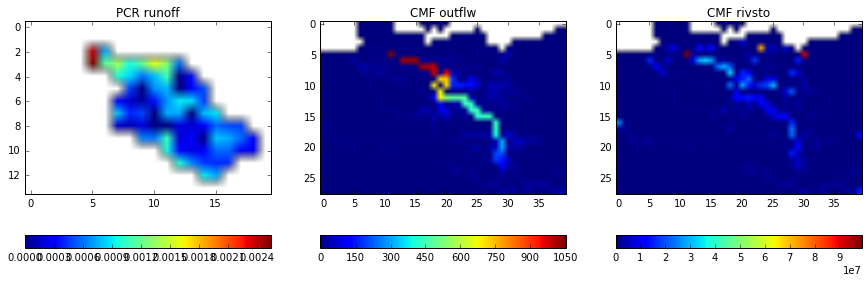

In [19]:
runoff = np.copy(PCR_bmi.get_var('runoff'))
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = np.copy(CMF_bmi.get_var('rivsto_out'))
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

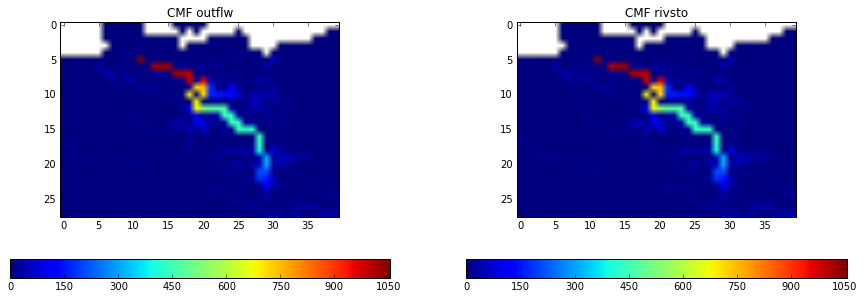

In [20]:
#- reassess location of CMF output point by comparing with simulated discharge
outflw = np.copy(CMF_bmi.get_var('outflw'))
outflw = np.ma.masked_greater(outflw, 1.e19)
test = np.copy(outflw)
test[6,13] = 1000

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,2,1)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,2,2)
imgplot = plt.imshow(test)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [21]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-22 18:49:06.296886
end time coupling:  2018-03-22 19:28:36.868531
average time per update PCR->CMF->DFM:  0:00:03.247358


## Finalize models

In [22]:
PCR_bmi.finalize()
CMF_bmi.finalize()
DFM_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-22 19:28:38,512 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-22 19:28:38,514 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## Check water balance PCR->CMF

In [23]:
CMF_logfile = os.path.join(CMF_out_dir, 'out/run_2000.log')
cmf_lf = open(CMF_logfile, 'r')
WB_error = float(cmf_lf.readlines()[-1].split()[-2]) * 10e9
print('Water balance error in CMF: {} m3'.format(WB_error))


Water balance error in CMF: 1.057e+11 m3


## Check water balance CMF->DFM

In [24]:
#- load DFM output file (from this model run)
fo = os.path.join(DFM_out_dir, 'DFM_OUTPUT_DFM_Elbe_VU/', 'DFM_Elbe_VU_his.nc')
no = Dataset(fo, 'r')
#- extract input precipitation from nc-file accumluated over time (for this run)
precip = no.variables['water_balance_precipitation']
#- select last entry
precip_tot = precip[-1]

print 'agreement of DFM input precipitation with output CMF volumes: ', precip_tot /  CMF_delta_vol_temp

agreement of DFM input precipitation with output CMF volumes:  0.998604225832


## Check water balance DFM

In [25]:
#- extract outflow accumluated over time from nc-file  (for this run)
bo_out = no.variables['water_balance_boundaries_out']
#- select last entry
bo_out = bo_out[-1]

In [26]:
DFM_Vend = np.sum(np.copy(DFM_bmi.get_var('vol1')))
DFM_Vdiff = DFM_Vend - DFM_Vstart
print 'difference in volumes END - START: ', DFM_Vdiff, '\n'

DFM_Vdiff1 = DFM_Vdiff - CMF_delta_vol_temp
print 'remaining difference after subtracting input volume: ', DFM_Vdiff1, '\n'

DFM_Vdiff2 = DFM_Vdiff1 + bo_out
print 'remaining difference after adding DFM outflow: ', DFM_Vdiff2, '\n'

print 'fraction of remaining difference compared to overall DFM volumes: ',  np.absolute(DFM_Vdiff2) / DFM_Vend

difference in volumes END - START:  4568788770.2 

remaining difference after subtracting input volume:  -41728280241.8 

remaining difference after adding DFM outflow:  -59374001.6511 

fraction of remaining difference compared to overall DFM volumes:  0.00917792770145


## Compare model results

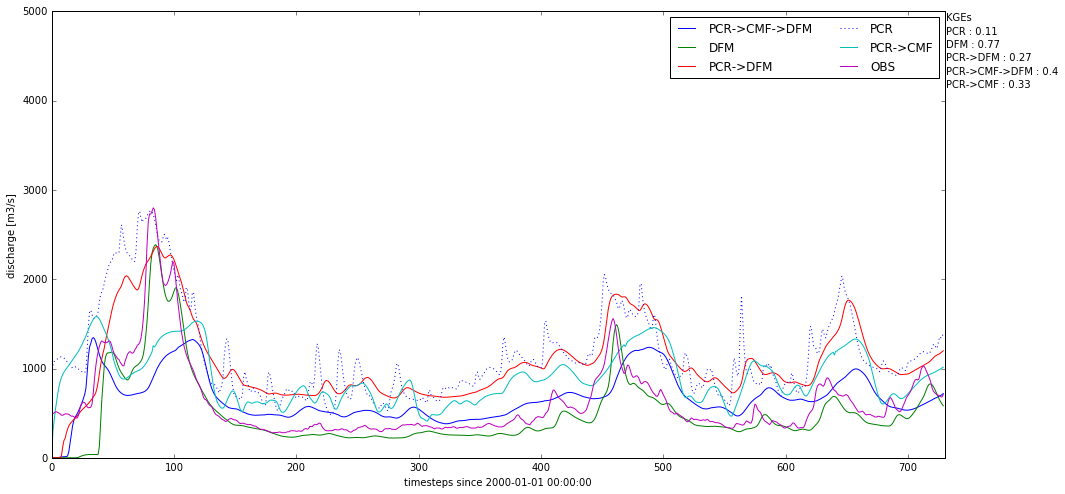

In [27]:
#- extract simulated discharge from nc-file (for this run)
qsim = no.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC = np.absolute(qsim[:,2])
qsim_ND = np.absolute(qsim[:,0])
qsim_downBC = np.absolute(qsim[:,1])
#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qobs_ND), len(qsim_ND), len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(qsim_ND):
    qsim_ND = qsim_ND[:minLength]
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND)
KGE_ND = np.round(KGE_ND,2)
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(len(qsim_ND)+1,4900, 'KGEs') 
plt.text(len(qsim_ND)+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(len(qsim_ND)+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(len(qsim_ND)+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(len(qsim_ND)+1,4300, 'PCR->CMF->DFM : '+str(KGE_ND))
plt.text(len(qsim_ND)+1,4150, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(out_dir, 'compareAndvalidate_Qsim_PCR2CMF2DFM.png'), dpi=300)

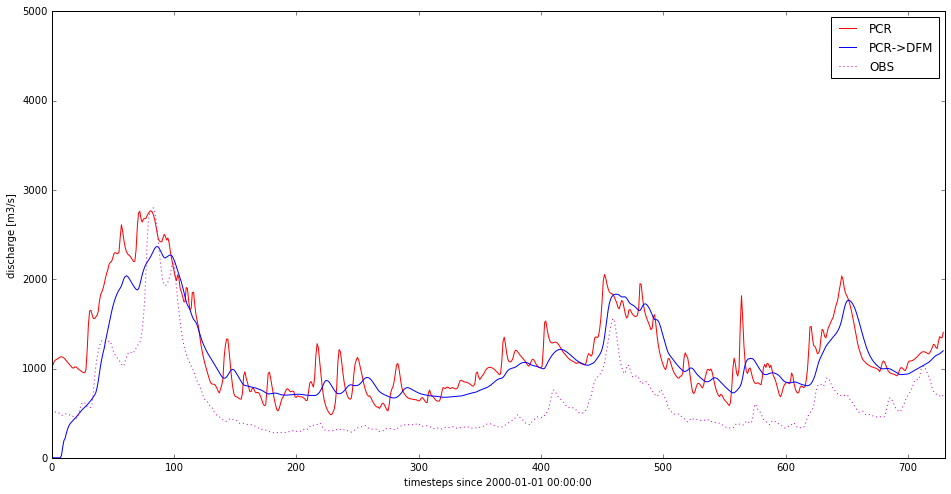

In [28]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

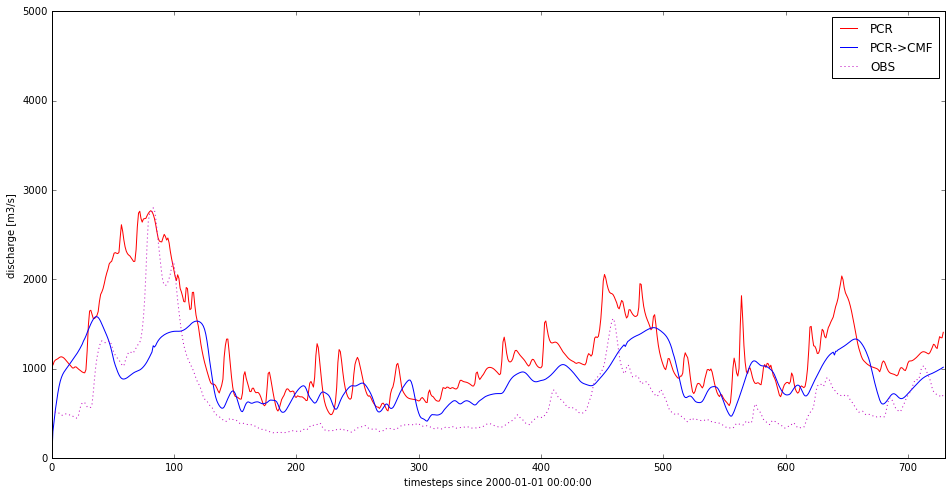

In [29]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

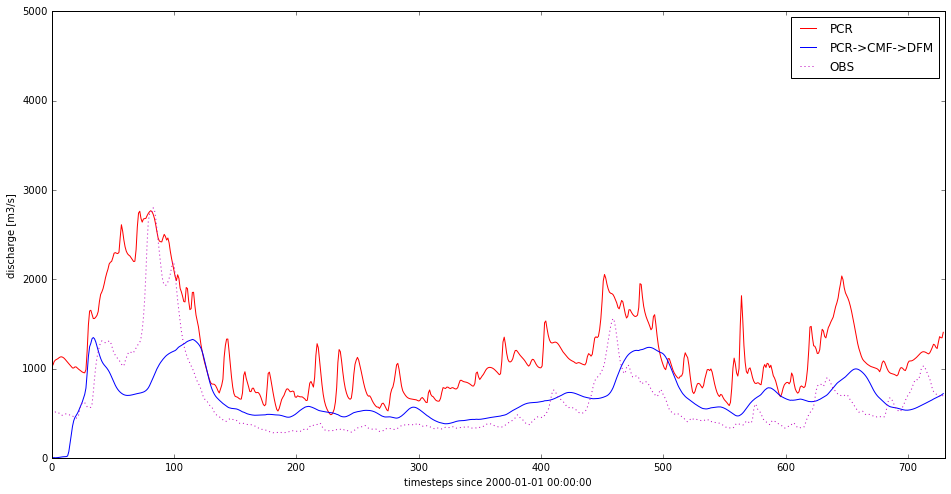

In [30]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(qsim_ND, 'b', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))

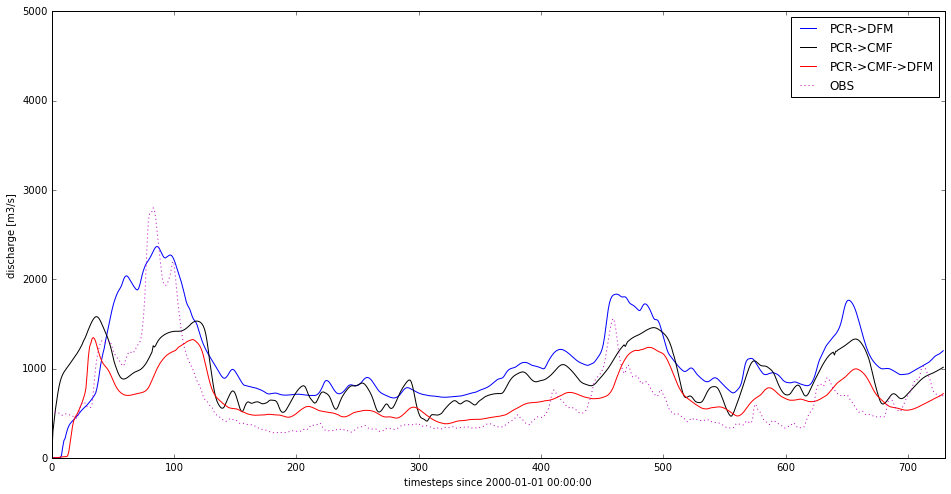

In [31]:
plt.figure(figsize=(16,8))
plt.plot(qsim_ND_1way, 'b', label = 'PCR->DFM')
plt.plot(cd, 'k', label = 'PCR->CMF')
plt.plot(qsim_ND, 'r', label = 'PCR->CMF->DFM')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))